In [210]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sympy
from sympy import symbols, sympify, lambdify, compose, I, pi, log, exp, simplify

In [211]:
import warnings

# Desactivar la advertencia de desbordamiento en potencias
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [212]:

# Extracción de datos

columna1 = []
columna2 = []
columna3 = []

with open('c:/Users/ximen/Desktop/Practicas DFI/hub_data_3.txt', 'r') as archivo:
    # Lee cada línea del archivo
    for linea in archivo: #cada linea es una fila del texto
        elementos = linea.split() # divide la línea en sus elementos utilizando espacios como delimitadores
        #print(elementos)
        columna1.append(elementos[0]) # Agrega cada elemento a su respectiva columna
        columna2.append(elementos[1])
        columna3.append(elementos[2])

z = np.zeros(len(columna1))
for i in range(len(columna1)):
  z[i] = float(columna1[i])

H = np.zeros(len(columna2))
for i in range(len(columna2)):
  H[i] = float(columna2[i])

desv = np.zeros(len(columna3))
for i in range(len(columna3)):
  desv[i] = float(columna3[i])

In [238]:
class GA:
    def __init__(self, num_poblacion_inicial, poblacion_base, operaciones_base):
        self.poblacion_base = poblacion_base
        self.operaciones_base = operaciones_base
        self.numero_inicial = num_poblacion_inicial

    def Simplificador(self, poblacion):
        x = symbols('x')
        expresiones_simplificadas = [simplify(expresion) for expresion in poblacion]
        return expresiones_simplificadas

    def Composicion(self, f1, f2):
        x = symbols('x')
        expresiones = [f1, f2]
        expresiones_sympy = [sympify(exp) for exp in expresiones] 
        f1 = expresiones_sympy[0]
        f2 = expresiones_sympy[1]
        # Se componen expresiones
        composicion = f1.subs(x, f2)
        return str(composicion)
    
    def Creador(self):
        Poblacion = np.zeros(self.numero_inicial, dtype=object)
        for n in range(0, self.numero_inicial):
            f1 = random.choice(self.poblacion_base)
            f2  = random.choice(self.poblacion_base)
            operador = random.choice(self.operaciones_base)

            if operador == 'comp':
                kid = self.Composicion(f1, f2)
                Poblacion[n] = kid
            else:
                kid= f"{f1} {operador} {f2}"
                Poblacion[n] = kid
        
        return Poblacion
    
    def Reproductor(self, Funciones_seleccionadas, porcentaje_mutacion, cantidad_hijos): 
        
        combinados = np.zeros(len(Funciones_seleccionadas)*cantidad_hijos, dtype=object)

        for j, funcion in enumerate(Funciones_seleccionadas):
            operaciones_para_combinacion = [random.choice(self.operaciones_base) for i in range(cantidad_hijos)]
            funciones_a_combinar = [random.choice(Funciones_seleccionadas) for i in range(cantidad_hijos)]
            for n in range(0, len(operaciones_para_combinacion)):
                if operaciones_para_combinacion[n] == 'comp':
                    kid = self.Composicion(funcion, funciones_a_combinar[n])
                    combinados[n + 6*j] = kid
                else: 
                    kid = f"({funcion}) {operaciones_para_combinacion[n]} ({funciones_a_combinar[n]})"
                    combinados[n + 6*j] = kid        

        # EMPIEZA MUTACION
        num_mutacion = int(len(combinados)*(porcentaje_mutacion/100))
        funciones_a_mutar = []
        mutaciones = np.zeros(num_mutacion, dtype=object)

        for n in range(0, num_mutacion): 
            expresion_m = random.choice(combinados)
            funciones_a_mutar.append(expresion_m)
            operacion = random.choice(self.operaciones_base)
            expresion2 = random.choice(self.poblacion_base)

            if operacion == 'comp':
                mutado = self.Composicion(expresion_m, expresion2)
                mutaciones[n] = mutado
            else: 
                mutado = f"({expresion_m}) {operacion} {expresion2}"
                mutaciones[n] = mutado

        mutaciones = mutaciones.tolist()
        indices_no_mutados = np.array([i for i, elem in enumerate(combinados) if elem not in funciones_a_mutar])
        funciones_sin_mutar = combinados[indices_no_mutados].tolist()
        mutaciones += funciones_sin_mutar 
        
        return mutaciones
    
    def Calculador_Chi(self, Poblacion, z, H, desv):
        Chi = []
        x = symbols('x', real=True)
        expresiones_sympy = [sympify(exp) for exp in Poblacion]
        funciones_python = [lambdify(x, expresion, 'numpy') for expresion in expresiones_sympy]

        indices = []

        for n , funcion in enumerate(funciones_python):
            f = funcion(z)
            chi_value = np.sum(np.square((f - H) / desv))

            if not np.isinf(chi_value) and not np.isnan(chi_value):
                Chi.append(chi_value)
                indices.append(n)
                
        indices = np.array(indices)
        Poblacion = np.array(Poblacion)

        poblacion_nueva = Poblacion[indices].tolist()

        return np.array(Chi), poblacion_nueva
    
    def Seleccionador(self, mutaciones, Chi, porcentaje_seleccion):

        seleccion = np.percentile(Chi, porcentaje_seleccion)
        
        print('El chi menor fue: ' + str(min(Chi)))
        print('El chi MAYOR fue: ' + str(max(Chi)))
        print('La seleccion fue: ' + str(seleccion))

        Chi_seleccionados = Chi[Chi <= seleccion]
        indices = np.where(Chi <= seleccion)[0]
        funciones_seleccionadas = [mutaciones[i] for i in range(len(Chi)) if Chi[i] <= seleccion]

        combined_data = list(zip(Chi_seleccionados, funciones_seleccionadas))

        # Ordena la lista combinada por los elementos de x
        sorted_combined_data = sorted(combined_data, key=lambda pair: pair[0])

        # Desempaqueta los resultados ordenados
        Chis, funciones = zip(*sorted_combined_data)

        Funciones_seleccionadas = list(funciones)

        Chi_menor = min(Chis)

        return Funciones_seleccionadas, Chi_menor
    
    def Iteracion(self, num_generaciones, porcentaje_seleccion, porcentaje_mutacion, z, H, desv, numero_hijos):

        Generaciones = np.zeros(num_generaciones, dtype=object)
        Chi_menor = np.zeros(num_generaciones, dtype=object)

        for n in range(0, num_generaciones):
            print('Número de Generación:' +str(n))
            if n == 0:
                C= self.Creador()
                R = self.Reproductor(C, porcentaje_mutacion, numero_hijos)
                Cal = self.Calculador_Chi(R, z, H, desv)
                S = self.Seleccionador(Cal[1], Cal[0], porcentaje_seleccion)
                Generaciones[0] = S[0]
                Chi_menor[0] = S[1]
                print('LONGITUD GENERACION INCIAL: ' + str(len(Generaciones[0])))

            else:
                R = self.Reproductor(Generaciones[n-1], porcentaje_mutacion, numero_hijos)
                print('Se reproducen')
                Cal = self.Calculador_Chi(R, z, H, desv)
                print('Se calcula Chi')
                S = self.Seleccionador(Cal[1], Cal[0], porcentaje_seleccion)
                print('Seleccion')
                Generaciones[n] = S[0]
                Chi_menor[n] = S[1]
                print('LONGITUD GENERACION: ' + str(len(Generaciones[n])))
        

        print('Simplificando...')
        Generacion_Final = self.Simplificador(Generaciones[-1])
        print('Fin!')
        
        return Generacion_Final, Chi_menor


In [263]:
class Generaciones:
    def __init__(self, num_poblacion_inicial, poblacion_base, operaciones_base):
        self.num = num_poblacion_inicial
        self.poblacion_base = poblacion_base
        self.operaciones_base = operaciones_base

    
    def Iteracion(self, num_generaciones, porcentaje_seleccion, porcentaje_mutacion, z, H, desv, numero_hijos):

        Generaciones = np.zeros(num_generaciones, dtype=object)
        Chi_menor = np.zeros(num_generaciones, dtype=object)

        A = GA(num_poblacion_inicial = self.num, poblacion_base=self.poblacion_base, operaciones_base=self.operaciones_base)

        for n in range(0, num_generaciones):
            print('Número de Generación:' +str(n))
            if n == 0:
                C= A.Creador()
                R = A.Reproductor(C, porcentaje_mutacion, numero_hijos)
                #R_s = A.Simplificador(R)
                Cal = A.Calculador_Chi(R, z, H, desv)
                S = A.Seleccionador(Cal[1], Cal[0], porcentaje_seleccion)
                Generaciones[0] = S[0]
                Chi_menor[0] = S[1]
                print('LONGITUD GENERACION INCIAL: ' + str(len(Generaciones[0])))

            else:
                R = A.Reproductor(Generaciones[n-1], porcentaje_mutacion, numero_hijos)
                print('Se reproducen')
                #R_s = A.Simplificador(R)
                Cal = A.Calculador_Chi(R, z, H, desv)
                print('Se calcula Chi')
                S = A.Seleccionador(Cal[1], Cal[0], porcentaje_seleccion)
                print('Seleccion')
                Generaciones[n] = S[0]
                Chi_menor[n] = S[1]
                print('LONGITUD GENERACION: ' + str(len(Generaciones[n])))
        

        #print('Simplificando...')
        #Generacion_Final = A.Simplificador(Generaciones[-1])
        print('Fin!')
        
        return Generaciones[-1], Chi_menor

In [289]:
B = Generaciones(num_poblacion_inicial= 5, poblacion_base = ['x', '(x)**x'], operaciones_base = ['*', '+', '-', 'comp'])

C = B.Iteracion(9, 20, 10, z, H, desv, 6)

Número de Generación:0
El chi menor fue: 3307.2497952968
El chi MAYOR fue: 1.2723541022478982e+41
La seleccion fue: 4166.131593283944
LONGITUD GENERACION INCIAL: 6
Número de Generación:1
Se reproducen
Se calcula Chi
El chi menor fue: 3187.600505367451
El chi MAYOR fue: 5.001172231428125e+258
La seleccion fue: 4376.568062521891
Seleccion
LONGITUD GENERACION: 9
Número de Generación:2
Se reproducen
Se calcula Chi
El chi menor fue: 3064.9073312131245
El chi MAYOR fue: 2.293687465303631e+177
La seleccion fue: 3582.7311930333094
Seleccion
LONGITUD GENERACION: 9
Número de Generación:3
Se reproducen
Se calcula Chi
El chi menor fue: 2359.2976896255395
El chi MAYOR fue: 8.03357806629289e+25
La seleccion fue: 3401.4109468150327
Seleccion
LONGITUD GENERACION: 9
Número de Generación:4
Se reproducen
Se calcula Chi
El chi menor fue: 2233.2033321924196
El chi MAYOR fue: 265406058.56882256
La seleccion fue: 3415.2991709485927
Seleccion
LONGITUD GENERACION: 7
Número de Generación:5
Se reproducen
Se calc

In [290]:
Chi = np.zeros(len(C[0]))
x = symbols('x')
expresiones_sympy = [sympify(exp) for exp in C[0]]

funciones_evaluadas = [lambdify(x, expr, 'numpy') for expr in expresiones_sympy]
valores_x_np = np.array(z)
H_np = np.array(H)
desv_np = np.array(desv)

for n, funcion_evaluada in enumerate(funciones_evaluadas):
    f = funcion_evaluada(valores_x_np)
    diferencia = (H_np - f)
    chi = np.sum((diferencia/desv_np)**2)
    Chi[n] = chi
seleccion = min(Chi)
seleccionados = Chi[Chi == seleccion]
indices = np.where(Chi == seleccion)[0]
funciones_seleccionadas = [C[0][i] for i in indices]

print(funciones_seleccionadas)
print(len(funciones_seleccionadas))

funcion = lambdify(x, funciones_seleccionadas[0], 'numpy')

evaluada = funcion(z)

['(((((((((((x)**x + (x)**x) + ((x)**x - x)) + (((x)**x + (x)**x) + ((x)**x * x))) + ((((x)**x * x) * ((x)**x + (x)**x)) + ((((x)**x * x) + ((x)**x + (x)**x)) + x))) + (x)**x) - ((((x) * ((x)**x + (x)**x)) + (((x)**x * x) * ((x)**x + (x)**x))) - ((((x)**x + (x)**x) + ((x)**x - x)) + (((x)**x * x) * (x))))) + (((((((x)**x + (x)**x) + ((x)**x - x)) + (((x)**x + (x)**x) + ((x)**x * x))) + ((((x)**x * x) * ((x)**x + (x)**x)) + ((((x)**x * x) + ((x)**x + (x)**x)) + x))) + (x)**x) - ((((x) * ((x)**x + (x)**x)) + (((x)**x * x) * ((x)**x + (x)**x))) - ((((x)**x + (x)**x) + ((x)**x - x)) + (((x)**x * x) * (x)))))) + (((((((x)**x + (x)**x) + ((x)**x - x)) + (((x)**x * x) * (x))) + ((((x)**x + (x)**x) + ((x)**x - x)) + ((((x)**x * x) + ((x)**x + (x)**x)) + x))) + (((((x)**x + (x)**x) + ((x)**x - x)) + (((x)**x + (x)**x) + ((x)**x * x))) + ((((x)**x + (x)**x) + ((x)**x - x)) + ((((x)**x * x) + ((x)**x + (x)**x)) + x)))) + ((((((x)**x * x) * ((x)**x + (x)**x)) + ((((x)**x * x) + ((x)**x + (x)**x)) 

Text(0.5, 1.0, 'Chi a lo largo de las generaciones')

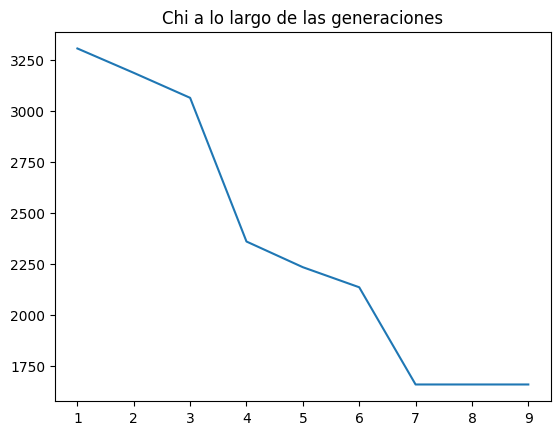

In [291]:
Chi_menor = C[1]

Gran_Chi = np.zeros(len(C[1]))

Numero_generacion = np.zeros(len(C[1]))

i = 1
for n in range(0, len(Chi_menor)):
    Numero_generacion[n] = i
    Gran_Chi[n] = (Chi_menor[n])
    i+=1

plt.plot(Numero_generacion, Gran_Chi)
plt.title('Chi a lo largo de las generaciones')

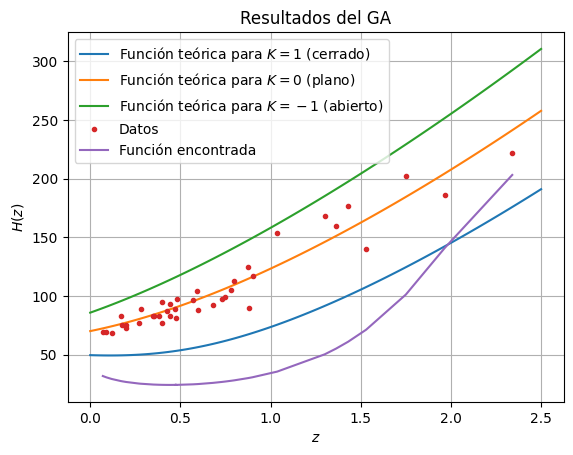

In [292]:
def H_bm(z, Omega_r, Omega_m, Omega_lambda, omega_DE, Omega_0): 
    return H_0*np.sqrt((Omega_r*(1+z)**(3*(1 + 1/3)) + Omega_m*(1+z)**3 + Omega_lambda*(1+z)**(3*(1+omega_DE)) + (1-Omega_0)*(1+z)**2))

H_0 = 70
O_r = 8.4*10**(-5)
O_m = 0.3
O_lambda = 0.7 - 8.4*10**(-5)
o_DE = -1
O_0 = [0.5, 1, 1.5]

# Se crea un arreglo de z para la función teórica
z_bu = np.linspace(0, 2.5, 100)

# hub_data_3.txt
H_teorico_plano = H_bm(z_bu,O_r, O_m, O_lambda, o_DE, O_0[1])
H_teorico_cerrado = H_bm(z_bu,O_r, O_m, O_lambda, o_DE, O_0[2])
H_teorico_abierto = H_bm(z_bu,O_r, O_m, O_lambda, o_DE, O_0[0])

plt.plot(z_bu, H_teorico_cerrado, label = 'Función teórica para $K = 1$ (cerrado)')
plt.plot(z_bu, H_teorico_plano, label = 'Función teórica para $K = 0$ (plano)')
plt.plot(z_bu, H_teorico_abierto, label = 'Función teórica para $K = -1$ (abierto)')


plt.plot(z, H, '.', label = 'Datos')
plt.plot(z, evaluada, label = 'Función encontrada')
plt.legend()
plt.xlabel('$z$')
plt.ylabel('$H(z)$')
plt.title('Resultados del GA')
plt.grid(True)
plt.show()

### Lo que siguen son borradores! 

Falta implementar el proceso de mutacion que sugirió el profe

In [248]:
A = GA(num_poblacion_inicial=5, poblacion_base = ['x', '(x)**x'], operaciones_base = ['*', '+', '-', '/', 'comp'])

In [249]:
intento1 = A.Iteracion(5, 20, 10, z, H, desv, 6)

# 5 generaciones = 3s

Número de Generación:0
El chi menor fue: 3720.7417119576153
El chi MAYOR fue: 9771266.439468281
La seleccion fue: 4110.859505001745
LONGITUD GENERACION INCIAL: 6
Número de Generación:1
Se reproducen
Se calcula Chi
El chi menor fue: 2719.0987791084494
El chi MAYOR fue: 4.971043787744775e+303
La seleccion fue: 4181.281553163899
Seleccion
LONGITUD GENERACION: 7
Número de Generación:2
Se reproducen
Se calcula Chi
El chi menor fue: 2590.0370921475883
El chi MAYOR fue: 7.845343964574067e+90
La seleccion fue: 3467.927972250347
Seleccion
LONGITUD GENERACION: 7
Número de Generación:3
Se reproducen
Se calcula Chi
El chi menor fue: 2354.170490855647
El chi MAYOR fue: 70329349.1859002
La seleccion fue: 3001.360482665269
Seleccion
LONGITUD GENERACION: 7
Número de Generación:4
Se reproducen
Se calcula Chi
El chi menor fue: 2942.4222406338504
El chi MAYOR fue: 608779527.4098194
La seleccion fue: 4292.880260750188
Seleccion
LONGITUD GENERACION: 7
Simplificando...
Fin!


In [250]:
Chi = np.zeros(len(intento1[0]))
x = symbols('x')
expresiones_sympy = [sympify(exp) for exp in intento1[0]]

funciones_evaluadas = [lambdify(x, expr, 'numpy') for expr in expresiones_sympy]
valores_x_np = np.array(z)
H_np = np.array(H)
desv_np = np.array(desv)

for n, funcion_evaluada in enumerate(funciones_evaluadas):
    f = funcion_evaluada(valores_x_np)
    diferencia = (H_np - f)
    chi = np.sum((diferencia/desv_np)**2)
    Chi[n] = chi
seleccion = min(Chi)
seleccionados = Chi[Chi == seleccion]
indices = np.where(Chi == seleccion)[0]
funciones_seleccionadas = [intento1[0][i] for i in indices]

print(funciones_seleccionadas)
print(len(funciones_seleccionadas))

funcion = lambdify(x, funciones_seleccionadas[0], 'numpy')

evaluada = funcion(z)

[x**(-3*x - 3)*(x**(x + 1)*(x + 2*x**(2*x) - (x**(x + 1)*(x**2 + 2*x**x) + 1)**2) + x**(2*x + 2)*(2*x**x + x**(x + 1) + (x + 2*x**(2*x))*(2*x**x + x**(x + 1)) + 1) + x**(3*x + 3)*(x**2 + 9*x**x + 4*x**(x + 2)))]
1


Text(0.5, 1.0, 'Chi a lo largo de las generaciones')

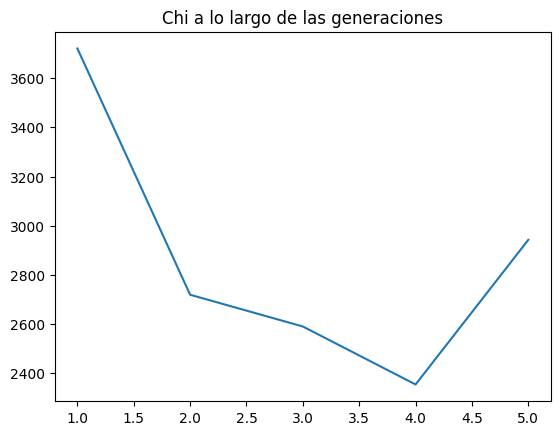

In [251]:
Chi_menor = intento1[1]

Gran_Chi = np.zeros(len(intento1[1]))

Numero_generacion = np.zeros(len(intento1[1]))

i = 1
for n in range(0, len(Chi_menor)):
    Numero_generacion[n] = i
    Gran_Chi[n] = (Chi_menor[n])
    i+=1

plt.plot(Numero_generacion, Gran_Chi)
plt.title('Chi a lo largo de las generaciones')

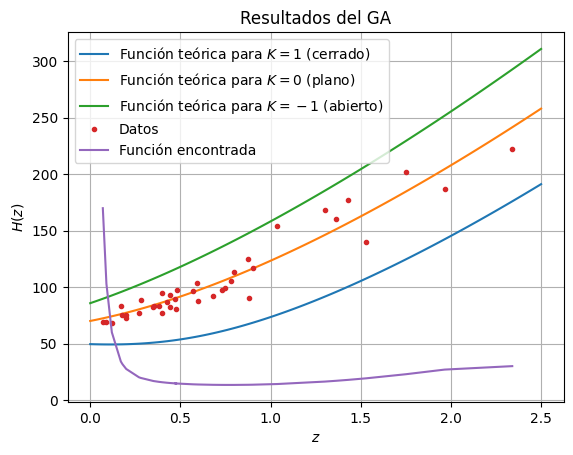

In [252]:
def H_bm(z, Omega_r, Omega_m, Omega_lambda, omega_DE, Omega_0): 
    return H_0*np.sqrt((Omega_r*(1+z)**(3*(1 + 1/3)) + Omega_m*(1+z)**3 + Omega_lambda*(1+z)**(3*(1+omega_DE)) + (1-Omega_0)*(1+z)**2))

H_0 = 70
O_r = 8.4*10**(-5)
O_m = 0.3
O_lambda = 0.7 - 8.4*10**(-5)
o_DE = -1
O_0 = [0.5, 1, 1.5]

# Se crea un arreglo de z para la función teórica
z_bu = np.linspace(0, 2.5, 100)

# hub_data_3.txt
H_teorico_plano = H_bm(z_bu,O_r, O_m, O_lambda, o_DE, O_0[1])
H_teorico_cerrado = H_bm(z_bu,O_r, O_m, O_lambda, o_DE, O_0[2])
H_teorico_abierto = H_bm(z_bu,O_r, O_m, O_lambda, o_DE, O_0[0])

plt.plot(z_bu, H_teorico_cerrado, label = 'Función teórica para $K = 1$ (cerrado)')
plt.plot(z_bu, H_teorico_plano, label = 'Función teórica para $K = 0$ (plano)')
plt.plot(z_bu, H_teorico_abierto, label = 'Función teórica para $K = -1$ (abierto)')


plt.plot(z, H, '.', label = 'Datos')
plt.plot(z, evaluada, label = 'Función encontrada')
plt.legend()
plt.xlabel('$z$')
plt.ylabel('$H(z)$')
plt.title('Resultados del GA')
plt.grid(True)
plt.show()